In [1]:
restart_df = False

# run from python
import scripts.label_image
import sys
import numpy as np
import tensorflow as tf
import os
from datetime import datetime
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageDraw, ImageFont
import time
import psutil
import pandas as pd


def load_graph(model_file):
  graph = tf.Graph()
  graph_def = tf.GraphDef()
  with open(model_file, "rb") as f:
    graph_def.ParseFromString(f.read())
  with graph.as_default():
    tf.import_graph_def(graph_def)
  return graph


def read_tensor_from_image_file(file_name, input_height=299, input_width=299,
				input_mean=0, input_std=255):
  input_name = "file_reader"
  output_name = "normalized"
  file_reader = tf.read_file(file_name, input_name)
  if file_name.endswith(".png"):
    image_reader = tf.image.decode_png(file_reader, channels = 3,
                                       name='png_reader')
  elif file_name.endswith(".gif"):
    image_reader = tf.squeeze(tf.image.decode_gif(file_reader,
                                                  name='gif_reader'))
  elif file_name.endswith(".bmp"):
    image_reader = tf.image.decode_bmp(file_reader, name='bmp_reader')
  else:
    image_reader = tf.image.decode_jpeg(file_reader, channels = 3,
                                        name='jpeg_reader')
  float_caster = tf.cast(image_reader, tf.float32)
  dims_expander = tf.expand_dims(float_caster, 0);
  resized = tf.image.resize_bilinear(dims_expander, [input_height, input_width])
  normalized = tf.divide(tf.subtract(resized, [input_mean]), [input_std])
  sess = tf.Session()
  result = sess.run(normalized)
  return result

def load_labels(label_file):
  label = []
  proto_as_ascii_lines = tf.gfile.GFile(label_file).readlines()
  for l in proto_as_ascii_lines:
    label.append(l.rstrip())
  return label


input_height = 224
input_width = 224
input_mean = 128
input_std = 128
input_layer = "input"
output_layer = "final_result"
label_file = r'/home/mmann1123/Documents/PiCameraClassifier/tf_files/retrained_labels_mobilenet_1.0_224.txt'
model_file = r'/home/mmann1123/Documents/PiCameraClassifier/tf_files/retrained_graph_mobilenet_1.0_224.pb'
 

###############################
# iterate across series of photos 
os.chdir(r'/home/mmann1123/Dropbox/Apps/PiCameraLogger/')
rootdir = os.getcwd()

# set up storage for classifications or load existing csv of classifications
if restart_df == True: 
    df = pd.DataFrame(columns=['Path','Date','Class','Prob'])
else:
    df = pd.read_csv('/home/mmann1123/Documents/PiCameraClassifier/predicted_labels.csv', index_col=0)

for dir, dirs, files in os.walk(rootdir):
    for file in files:
        if file == '.dropbox' or file =='predicted_labels.csv'or len(df[df['Path'].str.contains(file)])>0:
            #print(file + ' already exists in df')
            continue
        file_name = os.path.join(dir, file)
        graph = load_graph(model_file)
        t = read_tensor_from_image_file(file_name,input_height=input_height,input_width=input_width,input_mean=input_mean,input_std=input_std)
        input_name = "import/" + input_layer
        output_name = "import/" + output_layer
        input_operation = graph.get_operation_by_name(input_name)
        output_operation = graph.get_operation_by_name(output_name)
        with tf.Session(graph=graph) as sess:
            results = sess.run(output_operation.outputs[0],
                  {input_operation.outputs[0]: t})
        results = np.squeeze(results)
        top_k = results.argsort()[-5:][::-1]
        labels = load_labels(label_file)
        image = Image.open( file_name)
        font_type = ImageFont.truetype('/home/mmann1123/Documents/Fonts/unifont-10.0.07.ttf',25)
        draw = ImageDraw.Draw(image)
        draw.text(xy =(50,50),text=labels[top_k[0]]+' '+np.array2string(results[top_k[0]]),fill=(255,255,255), font=font_type)
        #image.show()
        
        #store path class date
        file_name2 = os.path.splitext(file_name)[0]
        date_in = file_name2.split("Picapture_")[1]
        date_time = datetime.strptime(date_in, "%d_%m_%Y-%H:%M:%S")
        df = df.append({'Path': file_name, 'Date': date_time, 'Class': labels[top_k[0]], 'Prob': results[top_k[0]]}, ignore_index=True) 
        #print(labels[top_k[0]], results[top_k[0]])



RuntimeError: module compiled against API version 0xc but this version of numpy is 0xa

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xa

KeyboardInterrupt: 

In [6]:
os.chdir(r'/home/mmann1123/Documents/PiCameraClassifier/')

df.to_csv('./predicted_labels.csv')

In [16]:
df = pd.read_csv('./predicted_labels.csv',)
df = df.loc[:,['Date','Path','Class','Prob']]
        date_time = 

df.tail()

,Date,Path,Class,Prob
18048,2018-04-15 19:52:01,/home/mmann1123/Dropbox/Apps/PiCameraLogger/15...,junk,0.768205
18049,2018-04-15 19:53:01,/home/mmann1123/Dropbox/Apps/PiCameraLogger/15...,junk,0.809259
18050,2018-04-15 19:54:01,/home/mmann1123/Dropbox/Apps/PiCameraLogger/15...,junk,0.823838
18051,2018-04-15 19:55:00,/home/mmann1123/Dropbox/Apps/PiCameraLogger/15...,junk,0.887674
18052,2018-04-15 19:56:00,/home/mmann1123/Dropbox/Apps/PiCameraLogger/15...,junk,0.915710


## FedEx Truck Counts 
Here we count the number of high probability FedEx truck based on a photo every 2 minutes. 

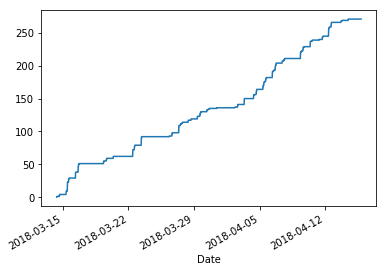

In [22]:
threshhold = 0.75
df.index =  pd.to_datetime(df.Date, format="%Y-%m-%d %H:%M:%S")
df.sort_index(inplace=True)
fedex = df.copy()
fedex = fedex.assign(Count=pd.Series([0] * len(fedex['Date'])).values)
fedex.loc[(fedex.Prob > threshhold) & (fedex.Class == 'fedex') ,'Count' ] =1
fedex = fedex.assign(CumSum=pd.Series(fedex.Count.cumsum()  ).values)
fedex.CumSum.plot()

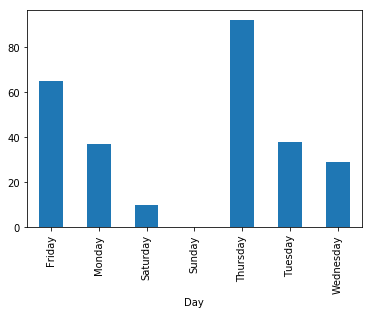

In [23]:
fedex = fedex.assign(Day=pd.Series(fedex.index.strftime('%A')).values)
fedex[['Day', 'Count']].groupby('Day').sum().plot(kind='bar', legend=None)



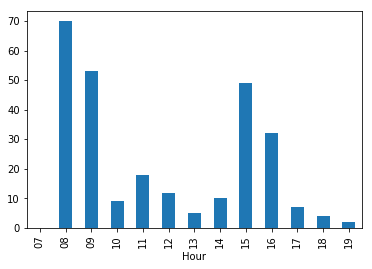

In [24]:
fedex = fedex.assign(Hour=pd.Series(fedex.index.strftime('%H')).values)
fedex[['Hour', 'Count']].groupby('Hour').sum().plot(kind='bar', legend=None)


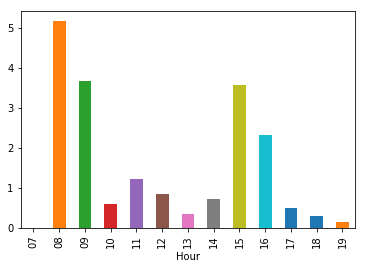

In [25]:
fedex.head(500)
fedex = fedex.assign(Ones=pd.Series([1] * len(fedex['Date'])).values)
image_h_count = fedex[['Hour', 'Ones']].groupby('Hour').sum()#.plot(kind='bar', legend=None)
fedex_h_count = fedex[['Hour', 'Count']].groupby('Hour').sum()
result = pd.concat([fedex_h_count, image_h_count], axis=1, join='inner')
result['p_fedex_image'] = result.Count / result.Ones * 100
result.p_fedex_image.plot(kind='bar')

## Bus Counts 
Here we count the number of high probability Buses based on a photo every 2 minutes. 

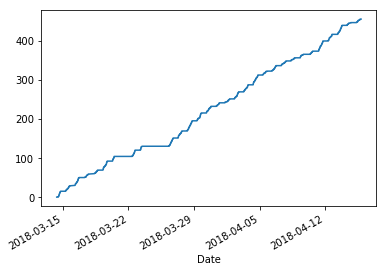

In [30]:
df.index =  pd.to_datetime(df.Date, format="%Y-%m-%d %H:%M:%S")
df.sort_index(inplace=True)
bus = df.copy()
bus = bus.assign(Count=pd.Series([0] * len(bus['Date'])).values)
bus.loc[(bus.Prob > threshhold) & (bus.Class == 'bus') ,'Count' ] =1
bus = bus.assign(CumSum=pd.Series(bus.Count.cumsum()  ).values)
bus.CumSum.plot()
 

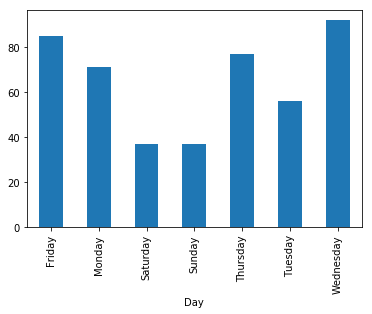

In [31]:
bus = bus.assign(Day=pd.Series(bus.index.strftime('%A')).values)
bus[['Day', 'Count']].groupby('Day').sum().plot(kind='bar', legend=None)


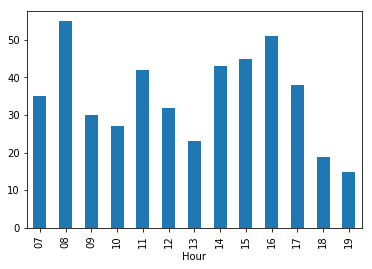

In [32]:
bus = bus.assign(Hour=pd.Series(bus.index.strftime('%H')).values)
bus[['Hour', 'Count']].groupby('Hour').sum().plot(kind='bar', legend=None)
